# Predict ETH price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime 

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_annual_metrics/eth_metrics_6.csv', parse_dates=True)

In [3]:
# Read in combined ETH Google trends data
eth_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/eth_google_trends/eth_trends_combined.csv', parse_dates=True)
eth_google_trends.reset_index(inplace=True)
eth_google_trends.rename(columns={'date':'time', 'ethereum':'ETH_Trends'},inplace=True)
eth_google_trends = eth_google_trends.drop(columns='index')
eth_google_trends['time'] = pd.to_datetime(eth_google_trends['time']).dt.date
eth_google_trends = eth_google_trends.set_index('time')
eth_google_trends.tail()

,ETH_Trends
time,
2021-07-30,22
2021-07-31,25
2021-08-01,28
2021-08-02,26
2021-08-03,27


In [4]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
211,2021-07-31 00:00:00+00:00,eth,617087,1.733664,2.974903e+11,529.372834,37.374311,2544.375376,1.169207e+08,1212322,7.959753e+09,22.283453
212,2021-08-01 00:00:00+00:00,eth,611381,1.739536,2.997877e+11,537.360990,54.531904,2563.737531,1.169339e+08,1190618,5.497474e+09,22.271858
213,2021-08-02 00:00:00+00:00,eth,648782,1.763162,3.062894e+11,548.166186,48.900070,2619.040999,1.169472e+08,1269470,6.263579e+09,22.258925
214,2021-08-03 00:00:00+00:00,eth,599206,1.705551,2.939115e+11,557.910614,40.842571,2512.915292,1.169604e+08,1219663,7.196205e+09,22.253252
215,2021-08-04 00:00:00+00:00,eth,605815,1.794226,3.190962e+11,562.148424,37.550755,2727.934254,1.169736e+08,1223841,8.497730e+09,22.250033


In [5]:
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [6]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/eth_annual_metrics/combined.csv')

In [7]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,eth_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends
time,,,,,,,,,,,,
2016-01-01,eth,2433,2.166056,7.010116e+07,0.483217,264.814266,0.920370,7.616628e+07,8233,264718.210777,1.362126,8.0
2016-01-02,eth,2486,2.226491,7.238322e+07,0.480767,370.221897,0.949990,7.619366e+07,9164,195513.065884,1.365054,4.0
2016-01-03,eth,2528,2.238090,7.294862e+07,0.494175,234.211669,0.957063,7.622134e+07,9258,311464.489292,1.369430,4.0
2016-01-04,eth,2623,2.222385,7.243632e+07,0.491670,626.141010,0.950000,7.624876e+07,9474,115686.914897,1.370961,5.0
2016-01-05,eth,2620,2.207573,7.189832e+07,0.492788,111.469298,0.942600,7.627660e+07,16430,645005.606026,1.384049,8.0


In [8]:
# Read in Relative Strength Index (RSI) data
rsi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_eth.csv', parse_dates=True, index_col='time')
rsi_eth.head()

,RSI_14
time,
2016-01-15,86.294443
2016-01-16,71.492294
2016-01-17,76.851959
2016-01-18,82.425741
2016-01-19,69.323486


In [9]:
# Read in Rate of Change (ROC) data
roc_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/roc_eth.csv', parse_dates=True, index_col='time')
roc_eth.head()

,ROC_14
time,
2016-01-15,40.257836
2016-01-16,27.558185
2016-01-17,36.974993
2016-01-18,54.341493
2016-01-19,43.544091


In [10]:
# Read in Money Flow Index (MFI) data
mfi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/mfi_eth.csv', parse_dates=True)
mfi_eth = mfi_eth.rename(columns={'Date':'time'})
mfi_eth['time'] = pd.to_datetime(mfi_eth['time']).dt.date
mfi_eth = mfi_eth.set_index('time').dropna()
mfi_eth

,MFI_14
time,
2015-08-20,62.228417
2015-08-21,64.727008
2015-08-22,64.183254
2015-08-23,61.727567
2015-08-24,60.543375
...,...
2021-08-02,86.588695
2021-08-03,83.045474
2021-08-04,83.688864


In [11]:
# Read in Stochastic Oscilator (STOCH) data
stoch_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/stoch_eth.csv', parse_dates=True)
stoch_eth = stoch_eth.rename(columns={'Date':'time'})
stoch_eth['time'] = pd.to_datetime(stoch_eth['time']).dt.date
stoch_eth = stoch_eth.set_index('time').dropna()
stoch_eth

,STOCHk_14_3_3,STOCHd_14_3_3
time,,
2015-08-24,40.927698,47.422852
2015-08-25,15.583200,37.190149
2015-08-26,-9.154127,15.785590
2015-08-27,-16.621943,-3.397623
2015-08-28,-14.739759,-13.505276
...,...,...
2021-08-01,85.107594,82.612265
2021-08-02,88.501460,84.669239
2021-08-03,84.688933,86.099329


In [12]:
# Read in True Strength (TSI) data
tsi_eth = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/tsi_eth.csv', parse_dates=True)
tsi_eth = tsi_eth.rename(columns={'Date':'time'})
tsi_eth['time'] = pd.to_datetime(tsi_eth['time']).dt.date
tsi_eth = tsi_eth.set_index('time').dropna()
tsi_eth

,TSI_13_25_13,TSIs_13_25_13
time,,
2016-01-25,74.789164,74.789164
2016-01-26,71.541862,74.325264
2016-01-27,69.057862,73.572778
2016-01-28,67.640674,72.725335
2016-01-29,65.330945,71.668993
...,...,...
2021-07-31,15.480453,-0.084473
2021-08-01,19.311808,2.686424
2021-08-02,23.140445,5.608427


In [13]:
# Create model features dataframe
features_eth = pd.concat([combined_df,rsi_eth,roc_eth,mfi_eth,stoch_eth,tsi_eth],axis=1).dropna()
features_eth.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,ETH_Trends,RSI_14,ROC_14,MFI_14,STOCHk_14_3_3,STOCHd_14_3_3,TSI_13_25_13,TSIs_13_25_13
time,,,,,,,,,,,,,,,,,,,
2016-01-25,eth,4148.0,4.168719,1.946165e+08,0.583595,46.667713,2.533722,7.681055e+07,17121.0,4.170261e+06,1.592616,34.0,90.762846,136.595916,92.622599,65.195665,70.206771,74.789164,74.789164
2016-01-26,eth,4417.0,3.875877,1.829184e+08,0.632694,65.300384,2.380587,7.683753e+07,16511.0,2.801184e+06,1.611841,35.0,81.858373,102.181554,67.531732,69.063015,68.403737,71.541862,74.325264
2016-01-27,eth,4172.0,3.881379,1.845734e+08,0.624104,68.361549,2.401310,7.686364e+07,18747.0,2.699959e+06,1.627927,16.0,82.114100,111.117152,71.983941,68.645435,67.634705,69.057862,73.572778
2016-01-28,eth,4568.0,4.034781,1.957973e+08,0.612189,106.987654,2.546453,7.689020e+07,16765.0,1.830092e+06,1.639420,21.0,83.833023,118.407078,74.128394,74.563754,70.757401,67.640674,72.725335
2016-01-29,eth,4424.0,3.917422,1.913399e+08,0.627430,100.408271,2.487635,7.691636e+07,16395.0,1.905619e+06,1.650181,17.0,80.458489,92.706848,65.816191,80.957423,74.722204,65.330945,71.668993


In [14]:
features_eth.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_eth.csv')

<AxesSubplot:title={'center':'EMA ETH'}, xlabel='time', ylabel='ETH Price ($)'>

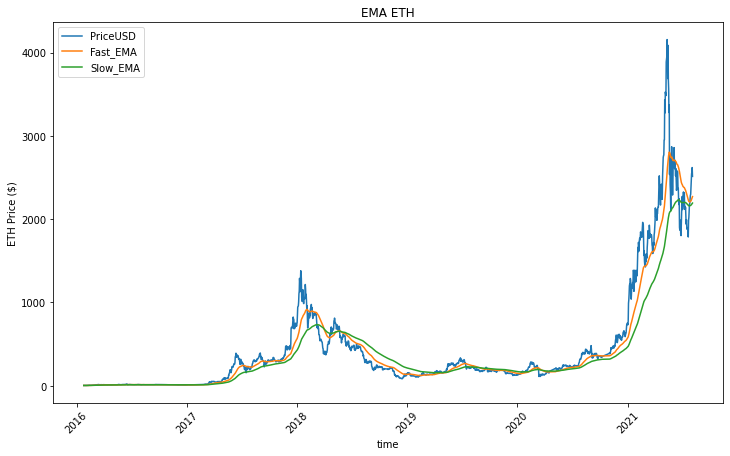

In [15]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals feature
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_eth['Fast_EMA'] = features_eth['PriceUSD'].ewm(halflife=short_window).mean()
features_eth['Slow_EMA'] = features_eth['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_eth[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA ETH', ylabel='ETH Price ($)', rot=45) 

In [16]:
# Construct a crossover trading signal
features_eth['Crossover_Long'] = np.where(features_eth['Fast_EMA'] > features_eth['Slow_EMA'], 1.0, 0.0)
features_eth['Crossover_Short'] = np.where(features_eth['Fast_EMA'] < features_eth['Slow_EMA'],-1.0, 0.0)
features_eth['Crossover_Signal'] = features_eth['Crossover_Long'] + features_eth['Crossover_Short']

In [17]:
# Calculate daily return
features_eth['Daily_Return'] = features_eth['PriceUSD'].pct_change()

In [19]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_eth['Positive_Return'] = np.where(features_eth['Daily_Return'] > 0, 1.0, 0.0)

features_eth = features_eth.dropna()

# Convert date to str to set test and train windows 
features_eth.index = pd.to_datetime(features_eth.index, format = '%Y/%m/%d')
features_eth.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,...,STOCHd_14_3_3,TSI_13_25_13,TSIs_13_25_13,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,,,
2016-01-26,eth,4417.0,3.875877,1.829184e+08,0.632694,65.300384,2.380587,7.683753e+07,16511.0,2.801184e+06,...,68.403737,71.541862,74.325264,2.455827,2.456623,0.0,-1.0,-1.0,-0.060439,0.0
2016-01-27,eth,4172.0,3.881379,1.845734e+08,0.624104,68.361549,2.401310,7.686364e+07,18747.0,2.699959e+06,...,67.634705,69.057862,73.572778,2.437022,2.437929,0.0,-1.0,-1.0,0.008705,1.0
2016-01-28,eth,4568.0,4.034781,1.957973e+08,0.612189,106.987654,2.546453,7.689020e+07,16765.0,1.830092e+06,...,70.757401,67.640674,72.725335,2.465818,2.465627,1.0,0.0,1.0,0.060443,1.0
2016-01-29,eth,4424.0,3.917422,1.913399e+08,0.627430,100.408271,2.487635,7.691636e+07,16395.0,1.905619e+06,...,74.722204,65.330945,71.668993,2.470489,2.470152,1.0,0.0,1.0,-0.023098,0.0
2016-01-30,eth,4449.0,3.779845,1.877914e+08,0.631556,79.022994,2.440670,7.694256e+07,14661.0,2.376414e+06,...,80.277937,62.548255,70.366031,2.465079,2.465066,1.0,0.0,1.0,-0.018880,0.0


In [20]:
# Select model features and timeframe for train data
X = features_eth[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','ETH_Trends','RSI_14', 'ROC_14','MFI_14','STOCHk_14_3_3','STOCHd_14_3_3','TSI_13_25_13','TSIs_13_25_13']]
X_train = X.loc['2016':'2020']

In [21]:
# Select prediction variable and timeframe for train data
y = features_eth['Positive_Return']
y_train = y['2016':'2020']

In [22]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [23]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [24]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [25]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Create the decision tree classifier instance and calculate the optimal tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.662904 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}


In [26]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10,n_estimators=20, n_jobs=-1)

In [27]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [28]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [29]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [30]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,51,42
Actual 1,31,91


Accuracy Score : 0.6604651162790698
Classification Report
              precision    recall  f1-score   support

         0.0       0.62      0.55      0.58        93
         1.0       0.68      0.75      0.71       122

    accuracy                           0.66       215
   macro avg       0.65      0.65      0.65       215
weighted avg       0.66      0.66      0.66       215



In [31]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-07-15,0.0,0.0
2021-07-16,0.0,0.0
2021-07-17,1.0,0.0
2021-07-18,0.0,0.0
2021-07-19,0.0,0.0
2021-07-20,0.0,0.0
2021-07-21,1.0,0.0
2021-07-22,1.0,0.0
2021-07-23,1.0,1.0


In [32]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.1506748193394909, 'RSI_14'),
 (0.09199255336992028, 'ROC_14'),
 (0.09129758467474962, 'STOCHd_14_3_3'),
 (0.08364220306591047, 'STOCHk_14_3_3'),
 (0.08130314904521059, 'MFI_14'),
 (0.061358452329484774, 'NVTAdj'),
 (0.05832734319422487, 'CapMVRVCur'),
 (0.05574428542584672, 'TxTfrValAdjUSD'),
 (0.05554218163249707, 'AdrActCnt'),
 (0.0549181895359465, 'CapMrktCurUSD'),
 (0.05375947043334166, 'VelCur1yr'),
 (0.05371800240600873, 'HashRate'),
 (0.05310084795363323, 'TxCnt'),
 (0.05078066264189101, 'ETH_Trends'),
 (0.0038402549518437106, 'Crossover_Signal')]

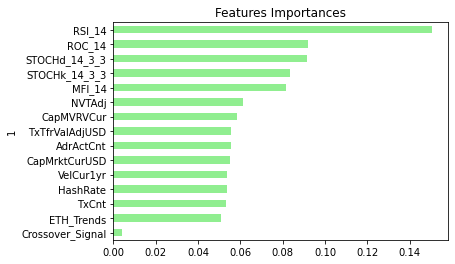

In [33]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [ ]:
# RSI is the most dominant feature which shows that ETH price is primarily determined by momentum.